In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
ed = tfp.edward2
import sys
sys.path.append("../")
from future_features import tape
import numpy as np
from plot_utils import plot_source_distributions, plot_ifa_parameters_and_ppc
%load_ext autoreload
%autoreload 2

/home/folzd/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from testsuite import MAP_model, neg_log_lik

/home/folzd/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/folzd/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/folzd/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/folzd/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/folzd/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/folzd/anaconda3/lib/python3.6/im

In [3]:
from tfpmodels import independentFactorAnalysis, centeredIndependentFactorAnalysis
from tfpmodels import centeredIndependentFactorAnalysisTest
from mapper import Mapper

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import FastICA, PCA

In [5]:
sess = tf.InteractiveSession()

In [6]:
n_components_in_mixture = 2
n_sources = 2
n_features = 2
n_observations = 5000

In [7]:
ifa = Mapper(centeredIndependentFactorAnalysis, 'ifa2', ['data'], n_observations=n_observations, n_components_in_mixture=n_components_in_mixture, n_features=n_features, n_sources=n_sources, mixture_component_var_concentration=.1*3, mixture_component_var_rate=1.*3,data_var_concentration=.1*3,data_var_rate=10.*3)
#ifa = Mapper(centeredIndependentFactorAnalysis, 'ifa2', ['data'], n_observations=n_observations, n_components_in_mixture=n_components_in_mixture, n_features=n_features, n_sources=n_sources, mixture_component_var_concentration=.1*3, mixture_component_var_rate=1.*3,data_var_concentration=.1*3,data_var_rate=10.*3)

In [8]:
ifa.unconstrained_variables

{'mixture_component_var': <tf.Variable 'ifa2/mixture_component_var:0' shape=(2, 2) dtype=float32_ref>,
 'mixture_weights': <tf.Variable 'ifa2/mixture_weights:0' shape=(2, 1) dtype=float32_ref>,
 'sources': <tf.Variable 'ifa2/sources:0' shape=(5000, 2) dtype=float32_ref>,
 'factor_loadings': <tf.Variable 'ifa2/factor_loadings:0' shape=(2, 2) dtype=float32_ref>,
 'data_var': <tf.Variable 'ifa2/data_var:0' shape=() dtype=float32_ref>}

In [9]:
generated = sess.run(ifa.tape)

In [12]:
fica = FastICA(n_components=n_sources).fit(generated['data']).mixing_.T

loss, train_op = ifa.adam_optimizer(data=generated['data'], learning_rate=0.005)
#loss, opt = ifa.bfgs_optimizer(data=generated['data'])

init_ops = [tf.global_variables_initializer()]
# Initialize in true parameters, as a sanity check
true_parameters = dict(generated)
true_parameters.pop('data')
init_ops.append(ifa.assigner(**true_parameters))

# FastICA, large SNR, uniformish mixing weight initialization
#init_ops.append(tf.assign(ifa.unconstrained_variables['factor_loadings'], fica,name='initialize_directions'))
#init_ops.append(tf.assign(ifa.unconstrained_variables['mixture_component_var'], 10*generated['data'].var()*np.random.rand(n_sources,n_components_in_mixture),name='initialize_signal_variance'))
#init_ops.append(tf.assign(ifa.unconstrained_variables['data_var'], 1e-3*np.ones(ifa.unconstrained_variables['data_var'].shape),name='initialize_noise_variance'))
#init_ops.append(tf.assign(ifa.unconstrained_variables['mixture_weights'], np.ones(ifa.unconstrained_variables['mixture_weights'].shape)/n_components_in_mixture,name='initialize_noise_variance'))

#initialized_parameters = sess.run(ifa.variables)
#initialized_parameters.pop('sources')
#train_nll_init = neg_log_lik(initialized_parameters,centeredIndependentFactorAnalysisTest,generated['data'])
#sess.run(tf.assign(ifa.unconstrained_variables['sources'], 2*np.ones(ifa.variable_shapes['sources'])))

accparams = []
learning_curve = []
def accumulate_parameters_and_loss(estimated_parameters, loss):
    accparams.append(estimated_parameters)
    learning_curve.append(loss)
sess.run([init_ops])
print(sess.run(ifa.map_neg_log_joint_fn(data=generated['data'])))
#opt.minimize(loss_callback=accumulate_parameters_and_loss,fetches=[ifa.variables, loss])
#opt.minimize(loss_callback=plot_stuff,fetches=[ifa.variables])

10058.693


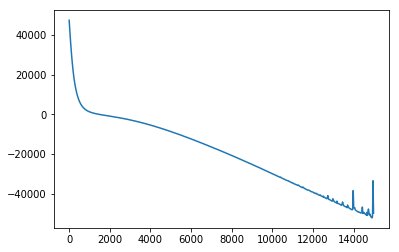

In [13]:
# ADAM training
t = []
num_epochs = 3000
sess.run(init_ops)
for i in range(num_epochs):
    sess.run(train_op)
    if i % 5 == 0:
        current_loss = sess.run(loss)
        t.append(current_loss)
plt.plot(np.arange(num_epochs,step=5)*5,t)

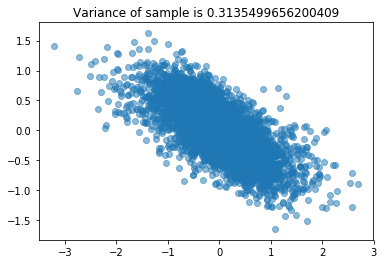

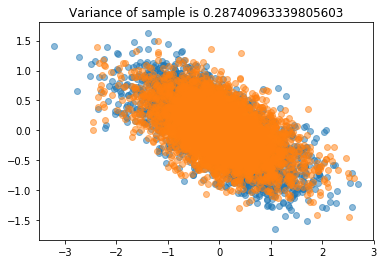

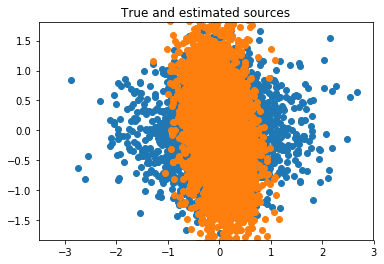

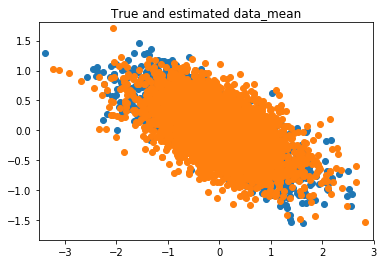

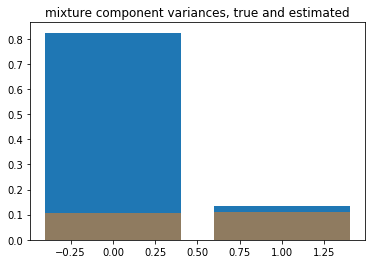

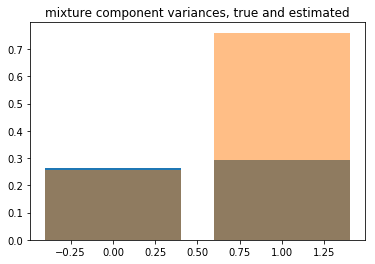

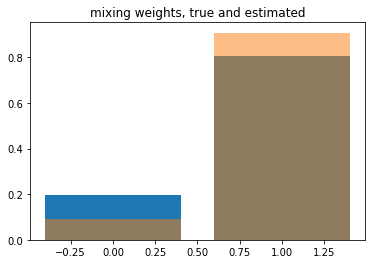

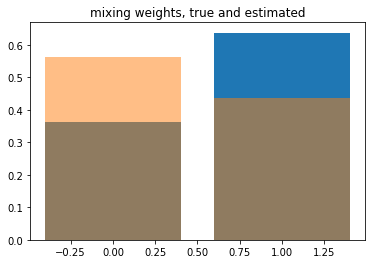

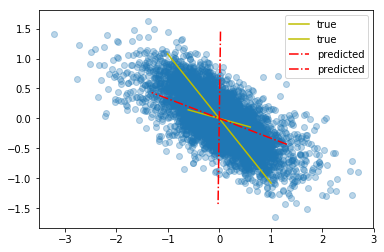

In [16]:
plot_ifa_parameters_and_ppc(sess.run(ifa.variables), generated, sess)

In [ ]:
learning_curve[0]

In [ ]:
plt.plot(learning_curve)
plt.ylim([-400000,400000])

In [ ]:
plot_ifa_parameters_and_ppc(accparams[-1], generated, sess)

In [ ]:
plot_ifa_parameters_and_ppc(accparams[0], generated, sess)

In [ ]:
true_parameters

In [ ]:
accparams[-1]

In [ ]:
plot_ifa_parameters_and_ppc(accparams[0], generated, sess)

In [ ]:
accparams[0]

In [ ]:
true_parameters

In [ ]:
accparams[0]

In [ ]:
true_parameters['data_var']

In [ ]:
true_parameters['sources'].var(0)

In [ ]:
map_estimates = dict(ifa.variables)
map_estimates.pop('sources')

In [ ]:
testmodel,source, data_mean = centeredIndependentFactorAnalysisTest(n_observations=n_observations, mc_samples=1, **map_estimates)
#source_sample = sess.run(source.distribution.sample((5000)))
#source_sample.var(0)

In [ ]:
plot_ifa_parameters_and_ppc(ifa.variables, generated, sess)

In [ ]:
train_nll = neg_log_lik(map_estimates,centeredIndependentFactorAnalysisTest,generated['data'])

In [ ]:
sess.run(train_nll_init)

In [ ]:
# run train_nll 100 times to estimate variance of the log-likelihood estimate
#train_nlls = []
#for i in range(100):
    #train_nlls.append(sess.run(train_nll_init))
#train_nlls = np.array(train_nlls)
#print(train_nlls)
#print(train_nlls.mean())
#print(train_nlls.std())

In [ ]:
generated_vars.pop('data')
train_nll_true_model = neg_log_lik(generated_vars,centeredIndependentFactorAnalysisTest,generated['data'])

In [ ]:
sess.run(train_nll_true_model)

In [ ]:
print(generated['mixture_component_var'])
print(map_estimate_vars['mixture_component_var'])

In [ ]:
print(generated['mixture_component_var'].mean(1))
print(map_estimate_vars['mixture_component_var'].mean(1))

In [ ]:
print(generated['data_var'])
print(map_estimate_vars['data_var'])

In [ ]:
plt.matshow(np.abs(cosine_similarity(generated['factor_loadings'],map_estimate_vars['factor_loadings'])),cmap='coolwarm',vmin=0,vmax=1)
plt.colorbar()

In [ ]:
generated_vars

In [ ]:
map_estimate_vars

In [ ]:
try:
    generated_vars.pop('sources')
except:
    pass
for param_pair in zip(generated_vars.values(),map_estimate_vars.values()):
    print(param_pair)
    print(np.allclose(*param_pair,rtol=0.001))

In [ ]:
param_pair

In [ ]:
np.allclose(*param_pair)